# 使用 Keras 進行貓狗辨識

## 0. 使用 Google Colabotary
如果不使用 Google Colabotary 則跳過 0.

### 使用 GPU
選單 Runtime / Change runtime type / Run time type 選  Python3
選單 Runtime / Change runtime type / Hardware accelerator 選 GPU

In [1]:
# 成功會出現 Found GPU at: /device:GPU:0

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### 授權 File

In [2]:
# 授權給 Google Drive
# 會有數個link，開啟後用Google帳號登入，將認證的code貼到框裡
# 成功會出現 Please enter the verification code: Access token retrieved correctly.

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131289 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# 指定當前的工作目錄
# 此處為google drive中的檔案路徑,drive為之前指定的工作根目錄，要加上

import os
os.chdir("drive/Colab Notebooks/Day_101_Fin")

In [5]:
# 查看當前工作目錄內容
# 本次題目，要將train、test檔案夾加入Google Drive

!ls

Day_101_Fin.ipynb  submission.csv  test  train


## 1. 載入套件

In [0]:
import os

# 載入基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 繪圖設定
from matplotlib import style
%matplotlib inline  
style.use('fivethirtyeight')

# 設定忽略警告訊息
import warnings
warnings.filterwarnings('ignore')

In [7]:
import tensorflow as tf

# 載入 Keras 預處理套件 - ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# 載入 Keras 其他深度學習套件
import keras
from keras import backend as K
from keras.applications import *
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.utils import to_categorical # Keras 做 One Hot Encoding 的函數
from keras.callbacks import EarlyStopping, ModelCheckpoint 

# 載入 Keras 已訓練好的模型
from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
# DenseNet201
# InceptionResNetV2
# InceptionV3
# MobileNet
# MobileNetV2
# NASNetMobile
# ResNet50
# VGG16
# VGG19
# Xception

Using TensorFlow backend.


In [0]:
# 其他相關套件
import random as rn
import cv2 
import glob
from PIL import Image
from tqdm import tqdm # 進度條顯示套件  

## 2. 設定參數

In [9]:
# 資料路徑
TRAIN_PATH = './train/'
TEST_PATH = './test/'
print(os.listdir(TRAIN_PATH))

# 設定執行參數
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8 # 設 32 效果會更好, 但要依照GPU上的記憶體量力而為, 如果跑不動可以降到 8 或更低
EPOCHS = 5
EARLY_STOP_PATIENCE = 3

# 設定圖片名稱對應的類別碼
CLASSES = ['dogs', 'cats']

['cats', 'dogs']


## 3. 資料預處理

In [0]:
# 設定 ImageDataGenerator
datagen = ImageDataGenerator(    
    rotation_range=10, #隨機旋轉角度的上限 (角度值 : 0 ~ 180)
    width_shift_range=0.2, # 左右隨機平移上限
    height_shift_range=0.2, # 上下隨機平移上限
    shear_range=0.2, # 逆時針的剪切變形角度
    zoom_range=0.2, # 影像倍率放大縮小的上限
    horizontal_flip=True, # 是否左右翻轉
    fill_mode='nearest', # 填補周圍空缺方法
    validation_split=0.2, # 測試集採樣比
    preprocessing_function=preprocess_input) # 資料前處理

In [11]:
# 設定輸入的 train / test 資料流
train_generator = datagen.flow_from_directory(TRAIN_PATH, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), classes=CLASSES,  
                                              batch_size=BATCH_SIZE, subset='training') # 設為訓練集
valid_generator = datagen.flow_from_directory(TRAIN_PATH, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]), classes=CLASSES, 
                                              batch_size=BATCH_SIZE, subset='validation') # 設為驗證集

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## 4. 模型與訓練
### 使用已訓練好的模型，做遷移學習

### Extract features

In [12]:
# base_model = ResNet50(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), input_tensor=None,
#                   weights='imagenet', include_top=False)
base_model = ResNet50(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), input_tensor=None,
                  weights='imagenet', pooling='avg', include_top=False)

# 設定凍結與要進行訓練的網路層
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
# x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.4)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# 顯示模型形狀
model.summary()

W0815 08:51:05.055486 140212888172416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 08:51:05.065185 140212888172416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 08:51:05.075598 140212888172416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0815 08:51:05.122458 140212888172416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0815 08:51:05.123696

94658560/94653016 [==============================] - 9s 0us/step


W0815 08:51:26.590288 140212888172416 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
# 設定模型收斂方式並編譯模型
model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0815 08:51:26.776218 140212888172416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# 設定 early stop (若 valid accuracy 沒有更好就提早停下) 與 call back (紀錄最好一次的模型參數)
early_stopping = EarlyStopping(monitor='val_acc', patience=EARLY_STOP_PATIENCE)
model_checkpoint = ModelCheckpoint("best_model_extract_feature.h5", save_best_only=True)

In [15]:
# 執行, 並將結果儲存於 history 物件中
history_extract_features = model.fit_generator(train_generator, steps_per_epoch=train_generator.samples // BATCH_SIZE,                              
                              validation_data=valid_generator, validation_steps=valid_generator.samples // BATCH_SIZE,
                              use_multiprocessing=False, verbose=1, epochs=EPOCHS,
                              workers=4, callbacks=[early_stopping, model_checkpoint])

W0815 08:51:27.342503 140212888172416 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
400/400 [==============================] - 635s 2s/step - loss: 0.2701 - acc: 0.8903 - val_loss: 0.0778 - val_acc: 0.9700
Epoch 2/5
400/400 [==============================] - 461s 1s/step - loss: 0.1869 - acc: 0.9278 - val_loss: 0.0705 - val_acc: 0.9775
Epoch 3/5
400/400 [==============================] - 467s 1s/step - loss: 0.1760 - acc: 0.9278 - val_loss: 0.0478 - val_acc: 0.9812
Epoch 4/5
400/400 [==============================] - 205s 511ms/step - loss: 0.1783 - acc: 0.9353 - val_loss: 0.1938 - val_acc: 0.9350
Epoch 5/5
400/400 [==============================] - 61s 152ms/step - loss: 0.1955 - acc: 0.9256 - val_loss: 0.0733 - val_acc: 0.9788


### Fine-tune

In [34]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
print(len(model.layers))

# we chose to train the top 2 inception blocks, 
# i.e. we will freeze the first layers and unfreeze the rest:
FREEZE_LAYERS = len(model.layers)-7
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
    
model.summary()

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

early_stopping = EarlyStopping(monitor='val_acc', patience=EARLY_STOP_PATIENCE)
model_checkpoint = ModelCheckpoint("best_model_finetune.h5", save_best_only=True)

history_finetune = model.fit_generator(train_generator, steps_per_epoch=train_generator.samples // BATCH_SIZE,                              
                              validation_data=valid_generator, validation_steps=valid_generator.samples // BATCH_SIZE,
                              use_multiprocessing=False, verbose=1, epochs=EPOCHS,
                              workers=4, callbacks=[early_stopping, model_checkpoint])

178
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activa

## 5. 訓練結果可視化

In [0]:
def plot_history(history):
  # 顯示訓練集的 Loss 結果
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'val'])
  plt.show()
  print()

  # 顯示訓練集的 Accuracy 結果
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'val'])
  plt.show()
  print()

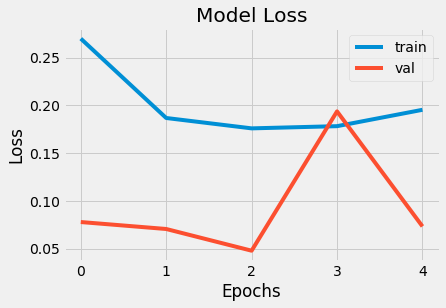

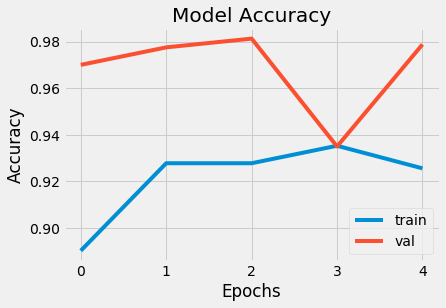

In [19]:
plot_history(history_extract_features)

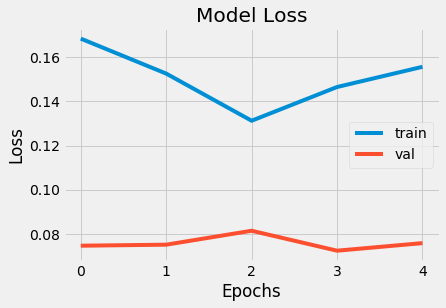

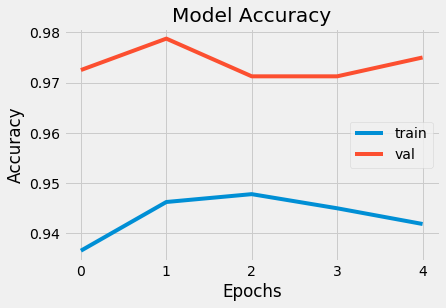

In [20]:
plot_history(history_finetune)

## 6. 預測與輸出

In [0]:
# 設定最後的輸出資料
X_test = list()
id_test = []

In [26]:
# 使用 Keras 內建的載入寫法 
def load_image(img_path):
    img = image.load_img(img_path, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img 
def make_test_data():
    global X_test
    dir_path = TEST_PATH
    for img in tqdm(os.listdir(dir_path)):
        id_test.append(img[:-4])
        path = os.path.join(dir_path, img)
        img = load_image(path)
        img = np.squeeze(img, axis=0)
        X_test.append(np.array(img))
make_test_data()        
X_test = np.array(X_test)

100%|██████████| 400/400 [00:01<00:00, 221.28it/s]


In [1]:
# 重新載回最好一次的模型參數

# model_name = "best_model_extract_feature.h5"
model_name = "best_model_finetune.h5"

best_model = keras.models.load_model(model_name)
#model.load_weights(model_name)

NameError: ignored

In [2]:
# 輸出預測檔
pred = best_model.predict(X_test)
print(pred[:5], '\n')
pred_cat = pred[:, 1]
print(pred_cat[:5], '\n')
pred_digits = np.max(pred, axis=1)
print(pred_digits[:5], '\n')

sub = pd.DataFrame({'id': id_test, 'Predicted': pred_cat})
sub = sub.sort_values("id",ascending=True).reset_index(drop=True)
print(sub.iloc[:5, :])
sub.to_csv('submission.csv', index = False)

NameError: ignored